In [1]:
# Import the necessary library from TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# --- Configuration ---
# Define the size we want our images to be (224x224 pixels)
IMG_SIZE = (224, 224)
# Define how many images to process at once
BATCH_SIZE = 32
# Define the paths to your data
TRAIN_DATA_PATH = 'Brain Tumor MRI Dataset/Training'
TEST_DATA_PATH = 'Brain Tumor MRI Dataset/Testing'


# --- Create a Data Generator ---
# This tool will automatically prepare our images from the folders.
# It will also create new, slightly modified images to make our AI smarter (this is called data augmentation).
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Rescale pixel values from 0-255 to 0-1
    rotation_range=20,       # Randomly rotate images
    width_shift_range=0.2,   # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,         # Shear transformations
    zoom_range=0.2,          # Randomly zoom in on images
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest',     # How to fill in new pixels that may appear after a rotation or a shift
    validation_split=0.2     # Set aside 20% of the training images for validation
)

test_datagen = ImageDataGenerator(rescale=1./255) # For the test data, we only rescale it. No augmentation!


# --- Load the Data from Directories ---
# This command tells the generator to find the images in the folder, prepare them, and get them ready for training.
print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # We are classifying into multiple categories
    subset='training'         # Specify this is the training set
)

print("\nLoading Validation Data:")
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH,          # Use the same training directory
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'       # Specify this is the validation set
)

print("\nLoading Testing Data:")
test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


# --- Let's check what we've done ---
print("\nLet's see the classes we found:")
class_names = list(train_generator.class_indices.keys())
print(class_names)

# Optional: You can uncomment the code below to see a sample of your augmented images
# x, y = next(train_generator)
# plt.figure(figsize=(10, 10))
# for i in range(9):
#     plt.subplot(3, 3, i+1)
#     plt.imshow(x[i])
#     plt.title(class_names[y[i].argmax()])
#     plt.axis('off')
# plt.show()

Loading Training Data:
Found 4571 images belonging to 4 classes.

Loading Validation Data:
Found 1141 images belonging to 4 classes.

Loading Testing Data:
Found 1311 images belonging to 4 classes.

Let's see the classes we found:
['glioma', 'meningioma', 'notumor', 'pituitary']


In [2]:
# Import the libraries we need to build the model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# --- Step 1: Load the pre-trained VGG16 model ---
# We specify the input shape to match our images (224x224 with 3 color channels)
# `include_top=False` means we DON'T want the final classification layer from VGG16.
# `weights='imagenet'` means we want to use the knowledge it gained from the ImageNet dataset.
base_model = VGG16(input_shape=(224, 224, 3),
                   include_top=False,
                   weights='imagenet')


# --- Step 2: Freeze the base model ---
# We tell the model that the existing layers should not be trained again.
base_model.trainable = False


# --- Step 3: Add our own custom layers on top ---
# We build our new model sequentially, layer by layer.
model = models.Sequential([
    base_model,                               # Start with the frozen VGG16 base
    layers.Flatten(),                         # Take the output of the base and flatten it into a single long vector
    layers.Dense(512, activation='relu'),     # Add a new, fully-connected layer with 512 neurons to learn complex patterns
    layers.Dropout(0.5),                      # Add a dropout layer to prevent overfitting (it randomly turns off 50% of neurons during training)
    layers.Dense(4, activation='softmax')     # The final output layer. It has 4 neurons (one for each class) and 'softmax' gives us the probability for each class.
])


# --- Step 4: Compile the model ---
# Here we configure the model for training.
model.compile(optimizer='adam',                        # 'adam' is a popular and effective optimizer that controls the learning rate.
              loss='categorical_crossentropy',         # This is the best loss function for multi-class classification problems.
              metrics=['accuracy'])                    # We want to monitor the accuracy during training.


# --- Step 5: Print the model summary ---
# This will show us the architecture of our final model.
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,562,308 (105.14 MB)

 Trainable params: 12,847,620 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

C:\Users\Akhil S Kumar\OneDrive\Desktop\Brain_Tumor_AI\aienv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.6667 - loss: 1.3173 - val_accuracy: 0.7071 - val_loss: 0.7054
Epoch 2/15
  1/142 ━━━━━━━━━━━━━━━━━━━━ 3:22 1s/step - accuracy: 0.7188 - loss: 0.5020

C:\Users\Akhil S Kumar\OneDrive\Desktop\Brain_Tumor_AI\aienv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


142/142 ━━━━━━━━━━━━━━━━━━━━ 52s 357ms/step - accuracy: 0.7188 - loss: 0.5020 - val_accuracy: 0.7045 - val_loss: 0.7352
Epoch 3/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.7819 - loss: 0.5645 - val_accuracy: 0.6964 - val_loss: 0.7721
Epoch 4/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 50s 344ms/step - accuracy: 0.8750 - loss: 0.5705 - val_accuracy: 0.6973 - val_loss: 0.7934
Epoch 5/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.7940 - loss: 0.5316 - val_accuracy: 0.7214 - val_loss: 0.7462
Epoch 6/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 50s 347ms/step - accuracy: 0.7500 - loss: 0.4856 - val_accuracy: 0.7223 - val_loss: 0.7261
Epoch 7/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.8110 - loss: 0.5005 - val_accuracy: 0.7509 - val_loss: 0.6585
Epoch 8/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 50s 347ms/step - accuracy: 0.7812 - loss: 0.5901 - val_accuracy: 0.7268 - val_loss: 0.6672
Epoch 9/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.8222 - loss: 0.4621 - val_accurac

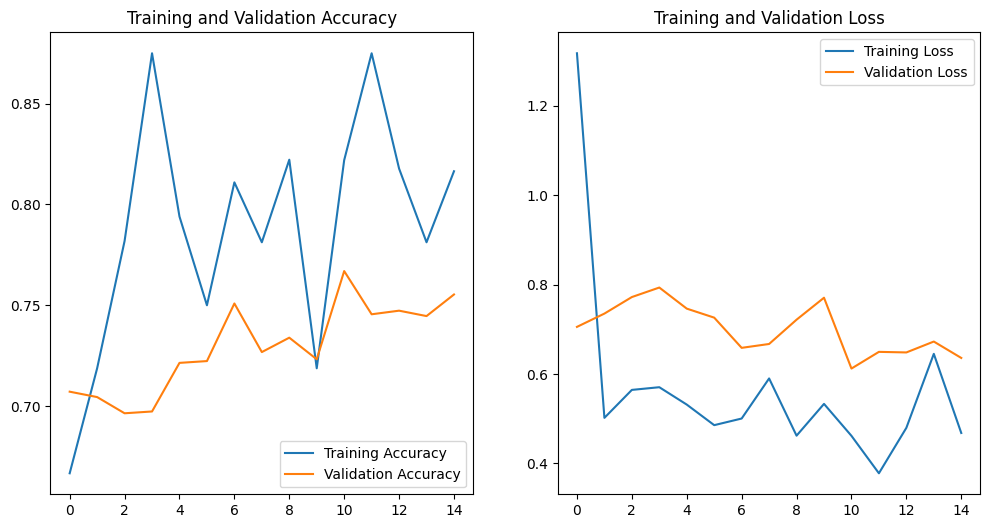

In [4]:
# --- Let's start the training process! ---
EPOCHS = 15

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# --- After training is done, let's evaluate the final model on the test set ---
print("\n--- Evaluating Model on Test Data ---")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss}")


# --- Now, let's visualize the training history ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os

# --- Step 1: Load your newly trained V2 model ---
# Make sure the path is correct
model_path = 'models/brain_tumor_model.h5'
model = tf.keras.models.load_model(model_path)
print(f"Model {model_path} loaded successfully.")


# --- Step 2: Define the prediction function (similar to the one in your web app) ---
def predict_single_image(model, img_path):
    # Load the image and resize it to the model's expected input size
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    
    # Add an extra dimension for the batch (the model expects a batch of images)
    img_batch = np.expand_dims(img_array, axis=0)
    
    # Rescale the pixel values to be between 0 and 1, just like the training data
    img_preprocessed = img_batch / 255.
    
    # Make the prediction
    prediction = model.predict(img_preprocessed)
    
    # Define the class names in the correct order
    # This must match the order from your 'train_generator'
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    # Find the class with the highest probability
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    confidence = np.max(prediction) * 100
    
    print(f"\n--- Analysis Result ---")
    print(f"Prediction: The model predicts this is a '{predicted_class_name}'.")
    print(f"Confidence: {confidence:.2f}%")


# --- Step 3: Run the test ---
# !!! IMPORTANT !!!
# Replace this path with the full path to the 'Huge_Meningioma.jpg' image on your computer.
# This is the image that the V1 model failed on.
test_image_path = r'C:\Users\Akhil S Kumar\OneDrive\Desktop\Brain_Tumor_AI\Brain Tumor MRI Dataset\Testing\meningioma\image.jpg' # <-- CHANGE THIS

# Check if the file exists before trying to predict
if os.path.exists(test_image_path):
    predict_single_image(model, test_image_path)
else:
    print(f"Error: The file was not found at '{test_image_path}'")
    print("Please make sure you have updated the path correctly.")

Model models/brain_tumor_model.h5 loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step

--- Analysis Result ---
Prediction: The model predicts this is a 'meningioma'.
Confidence: 30.29%
